In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


class_descriptions.pickle


In [ ]:
import numpy as np
import gensim, logging
import csv, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 100
num_words_description = 100
directory_prefix = "drive/My Drive/PatentStuff"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
	try:
		# Currently, memory growth needs to be the same across GPUs
		for gpu in gpus:
			tf.config.experimental.set_memory_growth(gpu, True)
			logical_gpus = tf.config.experimental.list_logical_devices('GPU')
	except RuntimeError as e:
		# Memory growth must be set before GPUs have been initialized
		print(e)


import random
import gensim.downloader as api
embedding_dim = 20
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

s=set(stopwords.words('english'))
#wv = gensim.models.KeyedVectors.load(directory_prefix+"/patents-small.wv", mmap='r')
wv = api.load("glove-wiki-gigaword-50")

porter = PorterStemmer()

placeholder_vec = [0 for _ in range(embedding_dim)]

def get_sentence_vector(sentence, num_words):
	ret = []
	sentence = map(lambda w: porter.stem(w.lower()), sentence)	
	for word in sentence:
		try:
			ret.append(wv[word])
		except:
			pass
	while len(ret) < num_words:
		ret.append(placeholder_vec)
	return np.vstack(ret[:num_words])

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])

def get_sentence_vector(sentence, num_words):
	ret = embed(sentence)
	ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
	ret = ret[:num_words]
	return ret
 
with open(directory_prefix+"/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:3]: get_sentence_vector(word_tokenize(remove_stopwords(val.lower())), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[==================================================] 100.0% 66.0/66.0MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
print(len(label_dict.keys()))

131


In [ ]:
def lstm_data_generator():
	current_dataframe = pd.read_csv(directory_prefix+'/dataset.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
	indices = np.random.choice(300000, 100000)
	for row in current_dataframe[indices]:
		label, description=row[0], row[1]
		lstm_input_patent = get_sentence_vector(word_tokenize(description.lower()), num_words)
		label_vectors = [z.strip().strip('\'\"')[:3] for z in label.split(',')]
		label_vectors = set([i for i in label_vectors if i in label_dict_keys])
		non_true_vectors = [label_dict[i] for i in random.sample(label_dict_keys, min(len(label_vectors), len(label_dict.keys()))) if i not in label_vectors]
		for l in (label_dict[i] for i in label_vectors):
			yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
		for l in non_true_vectors:
			yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})


#attention layer from https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
	def __init__(self, return_sequences=True):
		self.return_sequences = return_sequences
		super(attention,self).__init__()
		
	def build(self, input_shape):
		self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")
		self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),initializer="zeros")
		
		super(attention,self).build(input_shape)
		
	def call(self, x):
		e = K.tanh(K.dot(x,self.W)+self.b)
		a = K.softmax(e, axis=1)
		output = x*a
		
		if self.return_sequences:
			return output
		
		return K.sum(output, axis=1)
	def compute_output_shape(self,input_shape):
		return (input_shape[0],input_shape[-1])

	def get_config(self):
		return super(attention,self).get_config()

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(1, drop_remainder=True).prefetch(100).repeat()
test = tf.data.Dataset.from_generator(lstm_data_generator_test,  ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
test = test.batch(16, drop_remainder=True).repeat()


input_lstm = tf.keras.Input(shape=(num_words, embedding_dim), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description, embedding_dim), name='input_2')

#patent_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words, embedding_dim))(input_lstm)
#label_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_description, embedding_dim))(input_label)

layer_size = 100
#patent_lstm = tf.keras.layers.LSTM(num_words, input_shape=(num_words, embedding_dim), activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True
#, return_sequences=True)(patent_mask)
#label_lstm = tf.keras.layers.LSTM(num_words_description, input_shape=(num_words_description, embedding_dim), activation = 'tanh', recurrent_activation = 'sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True
#,return_sequences=True)(label_mask)

#att_patent = attention(return_sequences=True)(patent_mask)
#att_label = attention(return_sequences=True)(label_mask)

pooling_patent = tf.keras.layers.GlobalAveragePooling1D()(input_lstm)
pooling_label = tf.keras.layers.GlobalAveragePooling1D()(input_label)

dense_patent = tf.keras.layers.Dense(layer_size, activation='relu')(pooling_patent)
dense_label =  tf.keras.layers.Dense(layer_size, activation='relu')(pooling_label)
dense_patent = tf.keras.layers.Dense(layer_size, activation='relu')(dense_patent)
#dense_label =  tf.keras.layers.Dense(layer_size, activation='relu')(dense_label)
#dense_patent = tf.keras.layers.Dense(layer_size, activation='relu')(dense_patent)
dense_label =  tf.keras.layers.Dense(layer_size, activation='relu')(dense_label)
dense_patent = tf.keras.layers.Dropout(.1)(dense_patent)
dense_label=  tf.keras.layers.Dropout(.1)(dense_label)
concat = tf.keras.layers.Concatenate(axis=1)([dense_patent, dense_label])
dense = tf.keras.layers.Dense(int(layer_size*1.8), activation='relu')(concat)
dense = tf.keras.layers.Dense(int(layer_size*1.8), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size*1.8), activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, activation="sigmoid", name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)


9688


In [ ]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
	model.load_weights(directory_prefix+"/doublelstmcheckpoint1.h5")
except:
	pass

model.summary()
opt = tf.optimizers.Adam()
model.compile(loss=['binary_crossentropy'],
			  optimizer='adam',
			  metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"/doublelstmcheckpoint1.h5",
												 save_weights_only=False,
												 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 20)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 20)]    0                                            
__________________________________________________________________________________________________
global_average_pooling1d_8 (Glo (None, 20)           0           input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_9 (Glo (None, 20)           0           input_2[0][0]                    
______________________________________________________________________________________

Epoch 1/50
4986/5000 [============================>.] - ETA: 0s - loss: 0.6091 - accuracy: 0.6739
Epoch 00001: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


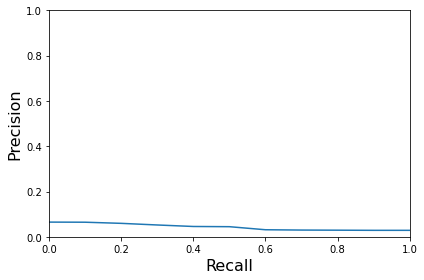

[0.0648987  0.06442063 0.05941476 0.05220857 0.04558326 0.04465264
 0.03117949 0.02976206 0.02921396 0.02859291 0.02859291]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.6096 - accuracy: 0.6726
Epoch 2/50
4981/5000 [============================>.] - ETA: 0s - loss: 0.5481 - accuracy: 0.7185
Epoch 00002: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 27s 27ms/step


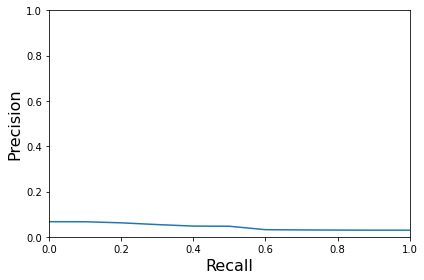

[0.06669634 0.0664392  0.06172668 0.05401601 0.04726742 0.04661365
 0.0314665  0.03040827 0.02962369 0.02927416 0.02926297]
5000/5000 [==============================] - 41s 8ms/step - loss: 0.5480 - accuracy: 0.7186
Epoch 3/50
4999/5000 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.7185
Epoch 00003: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


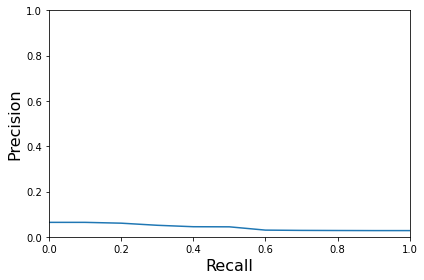

[0.06378052 0.06378052 0.06016395 0.05088347 0.04451378 0.04403817
 0.02952255 0.02829461 0.02777827 0.02739477 0.0273712 ]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.5454 - accuracy: 0.7186
Epoch 4/50
4987/5000 [============================>.] - ETA: 0s - loss: 0.5077 - accuracy: 0.7485
Epoch 00004: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


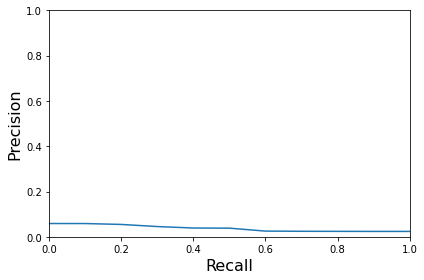

[0.05865994 0.05855738 0.05460075 0.04530423 0.03879426 0.03814799
 0.02518919 0.02435634 0.02402754 0.02381125 0.02380418]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.5071 - accuracy: 0.7490
Epoch 5/50
4992/5000 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.7512
Epoch 00005: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


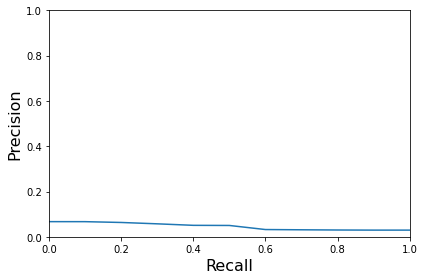

[0.06694488 0.06684684 0.06329877 0.05729975 0.0506568  0.05006281
 0.03204861 0.03096863 0.03002544 0.02951516 0.02950793]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.4978 - accuracy: 0.7514
Epoch 6/50
4990/5000 [============================>.] - ETA: 0s - loss: 0.4955 - accuracy: 0.7599
Epoch 00006: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


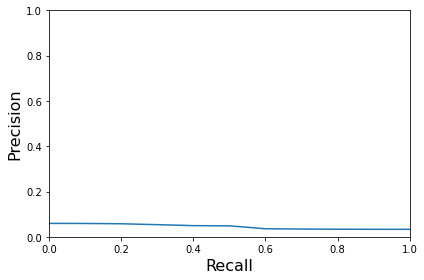

[0.05921013 0.05888207 0.05760793 0.053643   0.04936014 0.04835851
 0.03556074 0.03419785 0.03347639 0.03311403 0.03308002]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.4962 - accuracy: 0.7598
Epoch 7/50
4988/5000 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.7801
Epoch 00007: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


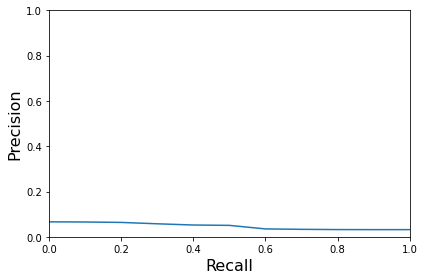

[0.06604694 0.06539668 0.06351885 0.05745065 0.05203015 0.0504609
 0.03484312 0.03300699 0.03193578 0.03168957 0.03168941]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.4820 - accuracy: 0.7802
Epoch 8/50
4998/5000 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.7729
Epoch 00008: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


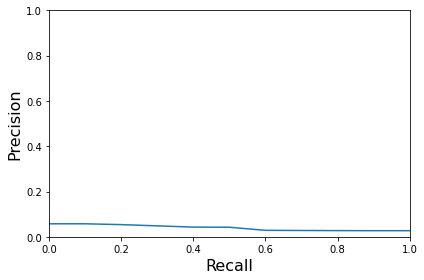

[0.05743931 0.05741153 0.05380517 0.04826664 0.04288066 0.04218402
 0.02860596 0.0279106  0.02734548 0.02696147 0.02695813]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.4781 - accuracy: 0.7730
Epoch 9/50
4981/5000 [============================>.] - ETA: 0s - loss: 0.4795 - accuracy: 0.7721
Epoch 00009: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


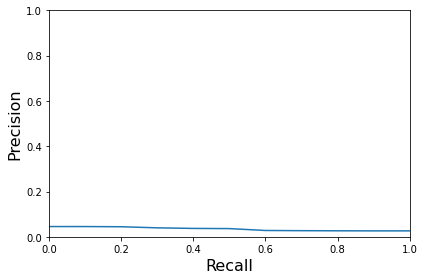

[0.04524787 0.04522223 0.0444299  0.03961646 0.03700537 0.03623974
 0.02789241 0.02705064 0.02651221 0.02619287 0.0261838 ]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.4790 - accuracy: 0.7728
Epoch 10/50
4988/5000 [============================>.] - ETA: 0s - loss: 0.4599 - accuracy: 0.7877
Epoch 00010: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 26s 26ms/step


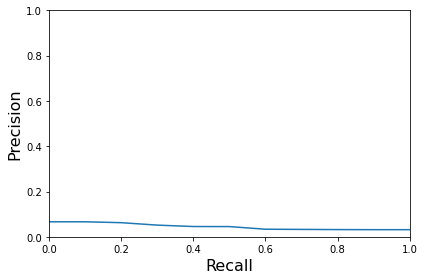

[0.0663122  0.0663122  0.06239203 0.05158965 0.04540064 0.0451473
 0.03344855 0.03268612 0.03190179 0.0314821  0.03146043]
5000/5000 [==============================] - 40s 8ms/step - loss: 0.4596 - accuracy: 0.7880
Epoch 11/50
4989/5000 [============================>.] - ETA: 0s - loss: 0.4659 - accuracy: 0.7885
Epoch 00011: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 25s 25ms/step


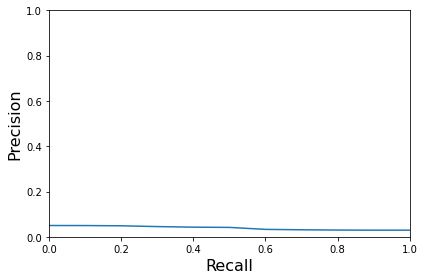

[0.0498633  0.04967099 0.04861695 0.04512896 0.04258469 0.04149233
 0.03278274 0.03103304 0.02978557 0.02928067 0.02927254]
5000/5000 [==============================] - 39s 8ms/step - loss: 0.4661 - accuracy: 0.7884
Epoch 12/50
4997/5000 [============================>.] - ETA: 0s - loss: 0.4760 - accuracy: 0.7821
Epoch 00012: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 25s 25ms/step


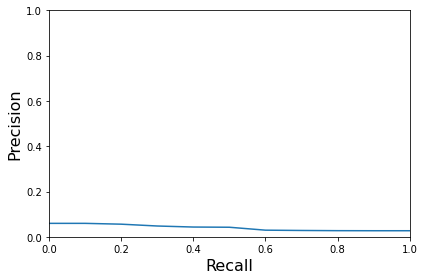

[0.0593908  0.0593908  0.0557381  0.04768871 0.04309741 0.04219951
 0.02929708 0.02795674 0.0270706  0.02678497 0.02677598]
5000/5000 [==============================] - 39s 8ms/step - loss: 0.4758 - accuracy: 0.7822
Epoch 13/50
4999/5000 [============================>.] - ETA: 0s - loss: 0.4597 - accuracy: 0.7836
Epoch 00013: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 27s 27ms/step


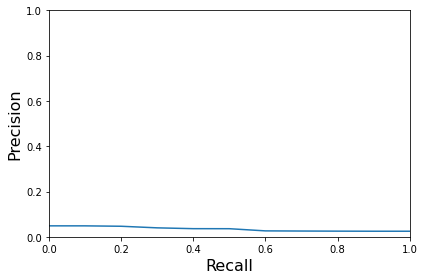

[0.04839616 0.04833505 0.0465714  0.03953843 0.03591831 0.03574349
 0.02615195 0.02546869 0.02495762 0.02460169 0.02459989]
5000/5000 [==============================] - 41s 8ms/step - loss: 0.4597 - accuracy: 0.7836
Epoch 14/50
4994/5000 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.7877
Epoch 00014: saving model to drive/My Drive/PatentStuff/doublelstmcheckpoint1.h5
131
  28/1000 [..............................] - ETA: 24s

In [ ]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=5000, callbacks=[cp_callback, prc_callback])

In [ ]:
def generate_prc():
	label_len = len(label_dict_keys)
	print(label_len)
	left = [label_dict[i] for i in label_dict_keys]
	predictions = []
	left_vectors = np.array(list(label_dict.keys()))
	label_vectors_vector = []
	num_tests = 1000
	def cur_gen():
		for row in pd.read_csv(directory_prefix+'/test_dataset.csv',sep=',', header = None).to_numpy():
			label, description=row[0], row[1]
			label_vectors = [z.strip().strip('\'\"')[:3] for z in label.split(',')]
			label_vectors = set([i for i in label_vectors if i in label_dict_keys])
			if label_vectors == set():
				continue
			label_vectors_vector.append(label_vectors)
			lstm_input_patent =  get_sentence_vector(word_tokenize(description.lower()), num_words)
			for i in left:
				yield ({'input_1':lstm_input_patent, 'input_2':i})

	dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_1':tf.float64, 'input_2':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}))
	dataset = dataset.batch(label_len).prefetch(50)
	predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
	n = 0
	d=0
	ns = []
	recalls = np.arange(0, 1.01, .1)
	ns = []
	for prediction, label_vectors in zip(predictions, label_vectors_vector):
		indices = np.flip(np.argsort(prediction, axis=0))
		e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
		cur = []
		total_ones = e.count(1)
		n = 0
		ones_seen = 0
		while ones_seen < total_ones:
			if e[n] == 1:
				ones_seen = ones_seen+1
			n = n+1
			cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
		new_cur = []
		for r in recalls:
			max_of_larger = max([i[0] for i in cur if i[1] >= r])
			new_cur.append(max_of_larger)
		ns.append(new_cur)
		#print(max(new_cur))
		d = d+1
		#print(float(d)/7215)
		#print(np.mean(np.vstack(ns), axis=0)[0])
	p = np.mean(np.array(ns), axis=0)
	np.save("newest_ps.npy", p)
	np.save("predictions.npy", predictions)
	np.save("label_vectors_vector.npy", label_vectors_vector)
	import matplotlib.pyplot as plt
	plt.plot(recalls, p)
	plt.ylim(0, 1)
	plt.xlim(0, 1)
	plt.margins(0.1)
	#plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
	plt.ylabel('Precision', fontsize=16)
	plt.xlabel('Recall', fontsize=16)
	plt.tight_layout()
	plt.show()
	print(p) 
	plt.savefig('binary_prc1.eps', format='eps')

In [ ]:

generate_prc()

131
200/200 [==============================] - 23s 115ms/step


ValueError: ignored